In [233]:
import torch, cv2
import numpy as np
from cotracker.utils.visualizer import Visualizer, read_video_from_path
from IPython.display import HTML, display
from base64 import b64encode
from cotracker.predictor import CoTrackerPredictor
import matplotlib.pyplot as plt
import json, subprocess, labelme, zarr, numcodecs, os
import PIL.Image as Image
from labelme import utils
import torch.nn.functional as F
from PIL import Image, ImageDraw

torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model = CoTrackerPredictor(
    checkpoint=os.path.join(
        './checkpoints/scaled_offline.pth'
    )
)

def extract_roi_around_point(pig, organ, recording, size, spectral_correction=False):
    """
    Extract a region of interest (ROI) from a 3D cube around a specified coordinate.

    Parameters:
    - cube: The input 3D cube (numpy array or zarr array).
    - coord: A tuple (x, y, z) specifying the center of the ROI.
    - size: A tuple (dx, dy, dz) specifying the size of the ROI in each dimension.

    Returns:
    - A numpy array containing the extracted ROI.
    """

    cubes = zarr.open_array(f"c:/github/occlusions/ischemia_models_pigs/processed_data/cubes_{'sc' if spectral_correction else 'no_sc'}/cubes_" + pig + '_' + organ + '_' + recording + '.zarr', mode='r')
    coords = np.load('c:/github/co-tracker/tracking_results/points_coords/' + pig + '_' + organ + '_' + recording + '.npy')
    rois = zarr.open_array(f"c:/github/occlusions/ischemia_models_pigs/processed_data/rois_{'sc' if spectral_correction else 'no_sc'}/roi_{pig.replace(' ','')}_{organ}_{recording}.zarr", 
                           mode="w",
                           shape = (cubes.shape[0],cubes.shape[1], size, size),
                           chunks=(1, cubes.shape[1],size, size),
                           dtype='float32',
                           compressor = numcodecs.Blosc(cname='zstd', clevel=3, shuffle=numcodecs.Blosc.BITSHUFFLE),
                           zarr_format=2
                           )

    half = size /2
    for i in range(cubes.shape[0]):
        rois[i] = cubes[i, :, int(coords[i][0][1] - half): int(coords[i][0][1] + half), int(coords[i][0][0] - half): int(coords[i][0][0] + half)]

def create_envelope_mask(width, height, points):
    mask = Image.new('L', (width, height), 0)
    ImageDraw.Draw(mask).polygon(points.flatten().tolist(), outline=1, fill=1)
    mask_np = np.array(mask)
    return mask_np

#select a point, and the model will track it
def select_points(frame, framenumber = 0):
    frame = frame.transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    frame = frame.astype(np.uint8)    # Convert to uint8 data type
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # RGB to BGR

    cv2.imshow('frame', frame)
    selected_points = []

    # Callback to capture the selected points
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
            selected_points.append((framenumber, x, y))
            print(f"Point selected: (t=0, x={x}, y={y})")

    cv2.setMouseCallback('frame', mouse_callback)

    while True:
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Exit on pressing 'q'
            break

    cv2.destroyAllWindows()

    queries = torch.tensor(selected_points, dtype=torch.float32)
    queries = queries.unsqueeze(0)

    if torch.cuda.is_available():
        queries = queries.cuda()
    return queries

# Create video file

In [225]:
import ffmpeg
organ = 'bowel'
pig = 'pig1'
recordings = ['baseline'] 
          
for recording in recordings:
    rgbs = zarr.open_array(f'c:/github/occlusions/ischemia_models_pigs/processed_data/cubes_sc/rgbs_{pig}_{organ}_{recording}.zarr', mode='r')

    fps = 1
    bgrs = [cv2.cvtColor(r.astype('uint8'), cv2.COLOR_RGB2BGR) for r in rgbs]
    height, width, _ = bgrs[0].shape

    #save to video 'video.mp4'
    video_writer = cv2.VideoWriter(f'videos/{pig}_{organ}_{recording}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for bgr in bgrs:
        video_writer.write(bgr)
    video_writer.release()

In [240]:
# vid = "pig2_kidney_baseline_occlusion_reperfusion_renal_artery"
vid = "pig1_bowel_reperfusion"
video = read_video_from_path("videos/" + vid + '.mp4')
video = torch.from_numpy(video).permute(0, 3, 1, 2)[None].float()

if torch.cuda.is_available():
    model = model.cuda()
    video = video.cuda()

video = video[:,:,:,:,:]

# Select points and track

In [145]:
queries = select_points(video[0][0].cpu().numpy())

chunk_size = 5 # Number of frames per chunk
pred_tracks = None
pred_visibility = None
total_chunks = (video.shape[1] + chunk_size - 1) // chunk_size

for i in range(0, video.shape[1], chunk_size):
    print(f"Processing chunk {i // chunk_size + 1} of {total_chunks}...")

    if i == 0:
        queries = queries
    else:
        queries = chunk_pred_tracks[0, -1,:,:]
        queries = torch.cat([torch.tensor([[0]], device=queries.device), queries], dim=1).unsqueeze(0)
    video_chunk = video[:, i:i+chunk_size, :, :]

    # Pad the last chunk if it has fewer frames
    if video_chunk.shape[1] < chunk_size:
        padding = (0, 0, 0, 0, 0, chunk_size - video_chunk.shape[1])  # Pad along dim=1
        video_chunk = F.pad(video_chunk, padding, mode='constant', value=0)
        chunk_pred_tracks = F.pad(chunk_pred_tracks, (0, 0, 0, 0, 0, chunk_size - chunk_pred_tracks.shape[1]), mode='constant', value=0)
        chunk_pred_visibility = F.pad(chunk_pred_visibility, (0, chunk_size - chunk_pred_visibility.shape[1]), mode='constant', value=0)
    else:
        chunk_pred_tracks, chunk_pred_visibility = model(video_chunk, queries=queries)

    if pred_tracks is None:
        pred_tracks = chunk_pred_tracks
        pred_visibility = chunk_pred_visibility
    else:
        pred_tracks = torch.cat([pred_tracks, chunk_pred_tracks], dim=1)
        pred_visibility = torch.cat([pred_visibility, chunk_pred_visibility], dim=1)

pred_tracks = pred_tracks[:,:video.shape[1], :, :]
pred_visibility = pred_visibility[:, :video.shape[1],:]

vis = Visualizer(
    save_dir='c:/github/co-tracker/tracking_results/videos',
    linewidth=3,
    mode='cool',
    tracks_leave_trace=-1
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename=vid)

Point selected: (t=0, x=275, y=109)
Processing chunk 1 of 7...
Processing chunk 2 of 7...
Processing chunk 3 of 7...
Processing chunk 4 of 7...
Processing chunk 5 of 7...
Processing chunk 6 of 7...
Processing chunk 7 of 7...
Video saved to c:/github/co-tracker/tracking_results/videos\pig2_bowel_baseline.mp4


tensor([[[[[13, 14, 11,  ...,  2,  4,  4],
           [18, 13,  8,  ..., 11,  1,  6],
           [12,  3,  8,  ...,  3, 11, 15],
           ...,
           [14,  8, 31,  ..., 10, 17,  0],
           [11, 20, 27,  ..., 12,  0,  0],
           [17, 19, 15,  ...,  7,  0,  3]],

          [[ 0,  1,  0,  ...,  1,  0,  0],
           [ 5,  0,  0,  ..., 10,  0,  0],
           [ 6,  0,  0,  ...,  0,  0,  4],
           ...,
           [16, 10, 19,  ...,  4,  8,  0],
           [ 0,  3,  5,  ...,  5,  3,  3],
           [ 0,  2,  0,  ...,  0,  4,  8]],

          [[ 0,  0, 11,  ...,  0,  0,  0],
           [ 2,  0,  8,  ...,  3,  0,  2],
           [13,  4, 11,  ...,  8,  9, 13],
           ...,
           [13,  7,  9,  ...,  0, 21,  4],
           [16, 25, 10,  ..., 15, 11, 11],
           [22, 24,  0,  ..., 10, 12, 16]]],


         [[[13, 14, 11,  ...,  2,  4,  4],
           [18, 13,  8,  ..., 11,  1,  6],
           [12,  3,  8,  ...,  3, 11, 15],
           ...,
           [14,  8, 31,  

In [51]:
np.save('c:/github/co-tracker/tracking_results/points_coords/' + vid + '.npy', pred_tracks[0, :, :, :].cpu().numpy())

In [ ]:
#liver pig 2 not well tracked
organ = 'liver'
pig = 'pig2'
recordings = ['baseline_occlusion_and_reperfusion']

for recording in recordings:
    for sc in [True, False]:
        extract_roi_around_point(pig, organ, recording, size=10, spectral_correction=sc)

# Track a grid of points along with a segmentation mask

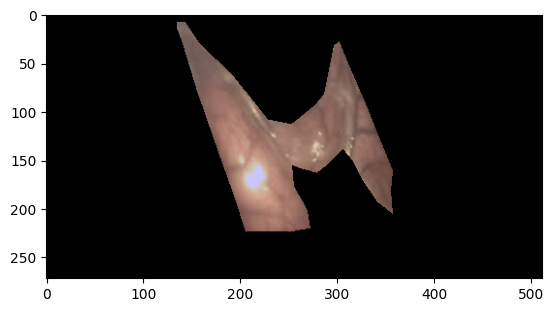

In [55]:
#get mask
def mask_using_labelme(rgb):

    #delete previous files
    if os.path.exists('image_to_annotate.jpg'):
        os.remove('image_to_annotate.jpg')
    if os.path.exists('labelme.json'):
        os.remove('labelme.json')
    
    image = Image.fromarray(rgb)
    image.save('image_to_annotate.jpg')
    subprocess.run(['labelme', 'image_to_annotate.jpg'])

    # run labelme in terminal and annotate. Save annotations to json file
    with open('labelme.json') as f:
        data = json.load(f)

    img = utils.img_b64_to_arr(data['imageData'])

    label_name_to_value = {shape['label']: i + 1 for i, shape in enumerate(data['shapes'])}
    lbl, _ = utils.shapes_to_label(img.shape, data['shapes'], label_name_to_value=label_name_to_value)
    return lbl.astype(np.uint8)

mask = mask_using_labelme(video[0][0].cpu().numpy().transpose(1, 2, 0).astype(np.uint8))  
plt.imshow((mask[...,None]*video[0,0].permute(1,2,0).cpu().numpy()/255.)) 

In [56]:
grid_size = 10
pred_tracks, pred_visibility = model(video, grid_size=grid_size, segm_mask=torch.from_numpy(mask)[None, None])

vis = Visualizer(
    save_dir='tracking_results_grid/videos',
    pad_value=100,
    linewidth=2,
)

vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename=vid)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (712, 472) to (720, 480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video saved to tracking_results_grid/videos\pig2_bowel_baseline.mp4


tensor([[[[[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]],

          [[255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           ...,
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255],
           [255, 255, 255,  ..., 255, 255, 255]]],


         [[[255, 255, 255,  ..., 255, 255, 255],
           [2

# Save envelope points and mask organ


In [243]:
queries = select_points(video[0][0].cpu().numpy())

chunk_size = 50  # Number of frames per chunk
pred_tracks = None
pred_visibility = None
total_chunks = (video.shape[1] + chunk_size - 1) // chunk_size

for i in range(0, video.shape[1], chunk_size):
    print(f"Processing chunk {i // chunk_size + 1} of {total_chunks}...")

    if i == 0:
        queries = queries
    else:
        queries = chunk_pred_tracks[0, -1, :, :]
        queries = torch.cat([torch.zeros(queries.shape[0], 1, device=queries.device), queries], dim=1).unsqueeze(0)  # Shape: (1, N, 3)
    video_chunk = video[:, i:i+chunk_size, :, :]

    # Pad the last chunk if it has fewer frames
    if video_chunk.shape[1] < chunk_size:
        padding = (0, 0, 0, 0, 0, chunk_size - video_chunk.shape[1])  # Pad along dim=1
        video_chunk = F.pad(video_chunk, padding, mode='constant', value=0)
        chunk_pred_tracks = F.pad(chunk_pred_tracks, (0, 0, 0, 0, 0, chunk_size - chunk_pred_tracks.shape[1]), mode='constant', value=0)
        chunk_pred_visibility = F.pad(chunk_pred_visibility, (0, chunk_size - chunk_pred_visibility.shape[1]), mode='constant', value=0)
    else:
        chunk_pred_tracks, chunk_pred_visibility = model(video_chunk, queries=queries)

    if pred_tracks is None:
        pred_tracks = chunk_pred_tracks
        pred_visibility = chunk_pred_visibility
    else:
        pred_tracks = torch.cat([pred_tracks, chunk_pred_tracks], dim=1)
        pred_visibility = torch.cat([pred_visibility, chunk_pred_visibility], dim=1)

pred_tracks = pred_tracks[:,:video.shape[1], :, :]
pred_visibility = pred_visibility[:, :video.shape[1],:]

vis = Visualizer(
    save_dir='c:/github/co-tracker/tracking_results_envelope/videos',
    linewidth=3,
    mode='cool',
    tracks_leave_trace=-1
)
vis.visualize(
    video=video,
    tracks=pred_tracks,
    visibility=pred_visibility,
    filename=vid)

Point selected: (t=0, x=144, y=244)
Point selected: (t=0, x=133, y=203)
Point selected: (t=0, x=129, y=145)
Point selected: (t=0, x=129, y=105)
Point selected: (t=0, x=134, y=59)
Point selected: (t=0, x=171, y=72)
Point selected: (t=0, x=231, y=94)
Point selected: (t=0, x=271, y=109)
Point selected: (t=0, x=308, y=103)
Point selected: (t=0, x=346, y=93)
Point selected: (t=0, x=362, y=98)
Point selected: (t=0, x=367, y=134)
Point selected: (t=0, x=367, y=175)
Point selected: (t=0, x=372, y=196)
Point selected: (t=0, x=353, y=182)
Point selected: (t=0, x=329, y=158)
Point selected: (t=0, x=325, y=141)
Point selected: (t=0, x=297, y=140)
Point selected: (t=0, x=260, y=136)
Point selected: (t=0, x=221, y=128)
Point selected: (t=0, x=195, y=134)
Point selected: (t=0, x=183, y=165)
Point selected: (t=0, x=187, y=201)
Point selected: (t=0, x=195, y=241)
Point selected: (t=0, x=177, y=256)
Point selected: (t=0, x=162, y=257)
Processing chunk 1 of 19...
Processing chunk 2 of 19...
Processing ch

tensor([[[[[15, 12,  6,  ...,  8, 16, 30],
           [16, 10,  7,  ..., 11, 25, 21],
           [ 5,  6, 15,  ...,  8,  5,  9],
           ...,
           [18, 30, 10,  ...,  7,  0,  0],
           [ 4,  7, 23,  ...,  3,  0,  4],
           [ 0,  0, 21,  ...,  4,  0,  5]],

          [[ 5,  2,  0,  ...,  1,  0,  9],
           [ 6,  0,  0,  ...,  4,  4,  0],
           [ 0,  0,  3,  ...,  0,  3,  7],
           ...,
           [ 5, 17, 17,  ...,  0,  4,  3],
           [13, 16,  4,  ...,  0,  2,  9],
           [ 5,  9,  2,  ...,  0,  2, 10]],

          [[ 6,  3,  0,  ..., 11,  0,  0],
           [ 7,  1,  1,  ..., 14,  0,  0],
           [ 8,  9, 17,  ...,  8,  1,  5],
           ...,
           [13, 25, 10,  ...,  4,  6,  5],
           [26, 29, 18,  ...,  0, 26, 33],
           [18, 22, 16,  ...,  0, 26, 34]]],


         [[[15, 12,  6,  ...,  8, 16, 30],
           [16, 10,  7,  ..., 11, 25, 21],
           [ 5,  6, 15,  ...,  8,  5,  9],
           ...,
           [18, 30, 10,  

In [245]:
np.save('c:/github/co-tracker/tracking_results_envelope/coords/' + vid + '.npy', pred_tracks[0, :, :, :].cpu().numpy())

In [246]:
cube_shape = (16,272,512)
def extract_masked_images(pig, organ, recording, spectral_correction=False):
    cubes = zarr.open_array(f"c:/github/occlusions/ischemia_models_pigs/processed_data/cubes_{'sc' if spectral_correction else 'no_sc'}/cubes_" + pig + '_' + organ + '_' + recording + '.zarr', mode='r')
    envelope_coords = np.load('c:/github/co-tracker/tracking_results_envelope/coords/' + pig + '_' + organ + '_' + recording + '.npy')
    results= zarr.open_array(f"c:/github/occlusions/ischemia_models_pigs/processed_data/segmented_{'sc' if spectral_correction else 'no_sc'}/{pig.replace(' ','')}_{organ}_{recording}.zarr", 
                        mode='w', 
                        shape=(cubes.shape[0], *cube_shape), 
                        chunks=(1, *cube_shape), 
                        dtype='float32', 
                        compressor=numcodecs.Blosc(cname='zstd', clevel=3, shuffle=numcodecs.Blosc.BITSHUFFLE),
                        zarr_format=2)
    
    for i in range(cubes.shape[0]):
        # Create a mask for the envelope
        mask = create_envelope_mask(cubes.shape[3], cubes.shape[2], envelope_coords[i])
        results[i] = cubes[i, :, :, :] * mask[None,:,:]

for sc in [True, False]:
    extract_masked_images('pig1', 'bowel', 'occlusion', spectral_correction=sc)

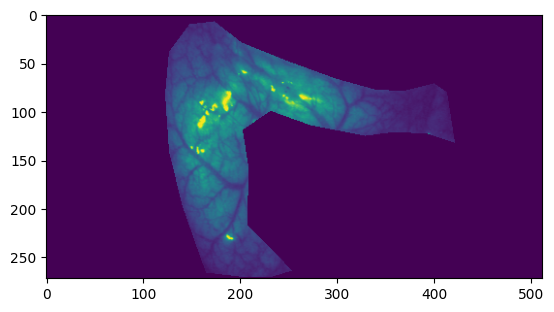

In [239]:
temp = zarr.open_array(f"c:/github/occlusions/ischemia_models_pigs/processed_data/segmented_sc/pig1_bowel_baseline.zarr", mode='r')
plt.imshow(temp[0][10])